## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "G:/Other_Datasets/dogscats/"
sz=299
arch=resnext50
bs=28

In [3]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [ ]:
learn.fit(1e-2, 1)
learn.precompute=False

In [ ]:
learn.fit(1e-2, 2, cycle_len=1)

In [4]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [5]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.043732   0.017736   0.995     
    1      0.039917   0.018211   0.992                                                                                 
    2      0.053764   0.020056   0.9925                                                                                



[0.02005604377860436, 0.9925000035762787]

In [6]:
learn.save('224_all_50')

In [7]:
learn.load('224_all_50')

In [8]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.995

## Analyzing results

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## A little further analysis

In [11]:
fn = data.val_ds.fnames[0]; fn

'valid\\cats\\cat.1001.jpg'

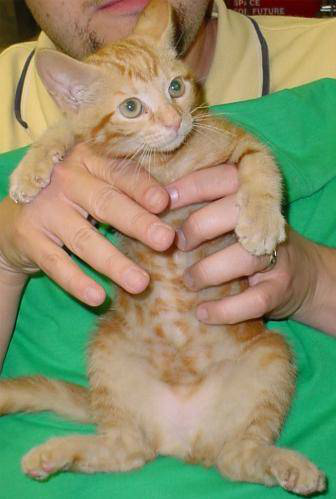

In [12]:
Image.open(PATH + fn)

In [19]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(np.array(Image.open(PATH+fn)))

In [20]:
preds = learn.predict_array(im[None])
np.argmax(preds)

1

In [25]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)

In [28]:
torch.cuda.empty_cache()
dump_tensors()

Parameter: GPU pinned 2048 × 1024 × 1 × 1
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048 × 1024 × 1 × 1
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048 × 1024 × 1 × 1
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048 × 1024 × 1 × 1
Parameter: GPU pinned 2048
Parameter: GPU pinned 2048
Parameter: GPU pinned 1024 × 1024 × 1 × 1
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024 × 32 × 3 × 3
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024 × 2048 × 1 × 1
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024 × 32 × 3 × 3
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024 × 2048 × 1 × 1
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024 × 32 × 3 × 3
Parameter: GPU pinned 1024
Parameter: GPU pinned 1024
Parameter: GPU pinned 64 × 3 × 7 × 7
Parameter

Tensor: GPU pinned 2048
Tensor: GPU pinned 
Tensor: GPU pinned 1024
Tensor: GPU pinned 1024
Tensor: GPU pinned 
Tensor: GPU pinned 1024
Tensor: GPU pinned 1024
Tensor: GPU pinned 
Tensor: GPU pinned 2048
Tensor: GPU pinned 2048
Tensor: GPU pinned 
Parameter: GPU pinned 2
Parameter: GPU pinned 2 × 512
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 512 × 4096
Parameter: GPU pinned 4096
Parameter: GPU pinned 4096
Tensor: GPU pinned 4096
Tensor: GPU pinned 4096
Tensor: GPU pinned 
Tensor: GPU pinned 512
Tensor: GPU pinned 512
Tensor: GPU pinned 
Tensor: GPU pinned 4096
Tensor: GPU pinned 4096
Tensor: GPU pinned 512 × 4096
Tensor: GPU pinned 512
Tensor: GPU pinned 512
Tensor: GPU pinned 512
Tensor: GPU pinned 2 × 512
Tensor: GPU pinned 2
Total size: 27273211
